# Classification of emotions from videos

## Importing the libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Loading the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Classification of Emotion/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

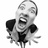

In [ ]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

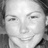

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/1.jpg')
image

### Train and test set

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/fer2013/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [ ]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

<ipython-input-19-b65b620cbff3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = train_dataset.classes, palette='Set2');


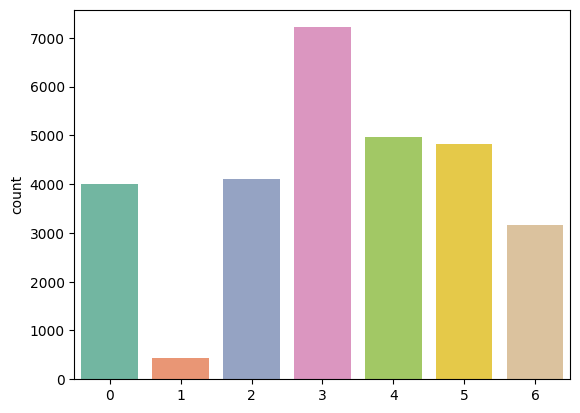

In [ ]:
sns.countplot(x = train_dataset.classes, palette='Set2');

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

In [ ]:
2*2*2*32

256

In [ ]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 70

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_20 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_21 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
network.fit(train_dataset, epochs=epochs)

Epoch 1/70
1795/1795 [==============================] - 74s 34ms/step - loss: 1.8494 - accuracy: 0.2680
Epoch 2/70
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5592 - accuracy: 0.3912
Epoch 3/70
1795/1795 [==============================] - 61s 34ms/step - loss: 1.3880 - accuracy: 0.4671
Epoch 4/70
1795/1795 [==============================] - 60s 33ms/step - loss: 1.3099 - accuracy: 0.5037
Epoch 5/70
1795/1795 [==============================] - 59s 33ms/step - loss: 1.2472 - accuracy: 0.5301
Epoch 6/70
1795/1795 [==============================] - 60s 34ms/step - loss: 1.2035 - accuracy: 0.5502
Epoch 7/70
1795/1795 [==============================] - 61s 34ms/step - loss: 1.1674 - accuracy: 0.5663
Epoch 8/70
1795/1795 [==============================] - 60s 34ms/step - loss: 1.1513 - accuracy: 0.5721
Epoch 9/70
1795/1795 [==============================] - 60s 34ms/step - loss: 1.1297 - accuracy: 0.5809
Epoch 10/70
1795/1795 [==============================] - 58s 33m

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights_emotions.hdf5')

<ipython-input-61-9cb5bbf306ff>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights_emotions.hdf5')


In [ ]:
with open('/content/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_16_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_16", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 48, 48, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": nul

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_20 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_21 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

## Evaluating the neural network

In [ ]:
network_loaded.evaluate(test_dataset)

3589/3589 [==============================] - 22s 6ms/step - loss: 1.5350 - accuracy: 0.5773


[1.534999966621399, 0.5773195624351501]

In [ ]:
predictions = network_loaded.predict(test_dataset)
predictions

3589/3589 [==============================] - 14s 4ms/step


array([[9.59110856e-01, 2.67754751e-03, 4.15813178e-03, ...,
        3.35310027e-03, 2.73941830e-02, 3.22471745e-03],
       [9.83534515e-01, 3.91445392e-05, 1.59775987e-02, ...,
        1.24906554e-04, 2.09945763e-04, 6.66854430e-06],
       [8.74967039e-01, 1.97133119e-03, 1.45387584e-02, ...,
        2.08688201e-03, 1.01210296e-01, 3.36034827e-05],
       ...,
       [1.47927739e-02, 4.23831603e-04, 1.34004265e-01, ...,
        5.65279333e-04, 5.20278793e-03, 8.45011055e-01],
       [9.52591596e-04, 1.93304936e-06, 6.67264983e-02, ...,
        8.95679928e-03, 2.57424032e-03, 9.20787573e-01],
       [2.29810942e-02, 1.33786525e-04, 9.94479656e-03, ...,
        4.13548527e-03, 2.80577294e-03, 9.55748141e-01]], dtype=float32)

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.5773195876288659

In [ ]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[309,   9,  34,  14,  59,  57,   9],
       [ 12,  33,   3,   2,   2,   2,   1],
       [ 81,   2, 212,  17,  66,  89,  61],
       [ 23,   1,   8, 778,  35,  15,  19],
       [ 99,  10,  92, 154, 113, 100,  58],
       [ 55,   4,  48,  29, 147, 302,   9],
       [ 13,   1,  33,  26,  11,   7, 325]])

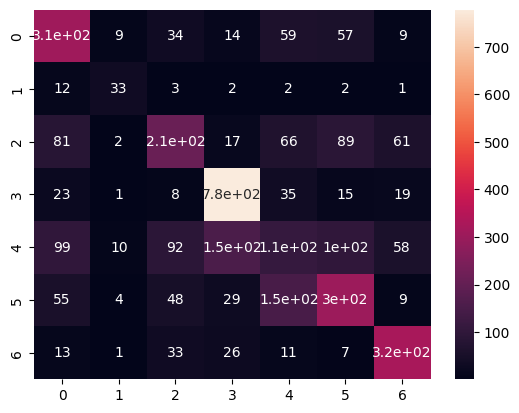

In [ ]:
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.52      0.63      0.57       491
           1       0.55      0.60      0.57        55
           2       0.49      0.40      0.44       528
           3       0.76      0.89      0.82       879
           4       0.26      0.18      0.21       626
           5       0.53      0.51      0.52       594
           6       0.67      0.78      0.72       416

    accuracy                           0.58      3589
   macro avg       0.54      0.57      0.55      3589
weighted avg       0.55      0.58      0.56      3589



## Classifying emotions in videos

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Classification of Emotion/emotion_test01.mp4')
connected, video = cap.read()
print(connected, video.shape)

True (360, 640, 3)


In [ ]:
face_detector = cv2.CascadeClassifier('/content/drive/MyDrive/Classification of Emotion/haarcascade_frontalface_default.xml')

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
# fourcc.org
save_path = '/content/drive/MyDrive/Classification of Emotion/emotion_test01_result.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

In [ ]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()
  if not connected:
    break
  faces = face_detector.detectMultiScale(frame, scaleFactor=1.2, minNeighbors=5, minSize=(30,30))
  if len(faces) > 0:
    for (x, y, w, h) in faces:
      frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
      roi = frame[y:y + h, x:x + w]
      roi = cv2.resize(roi, (48, 48))
      roi = roi / 255
      roi = np.expand_dims(roi, axis = 0)
      prediction = network_loaded.predict(roi)

      if prediction is not None:
        result = np.argmax(prediction)
        cv2.putText(frame, emotions[result], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

  cv2_imshow(frame)
  output_video.write(frame)

print('End')
output_video.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.